In [9]:
!pip install xgboost scikit-learn tensorflow

  Using cached xgboost-3.0.1-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.4-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp312-cp312-win_amd64.whl.metadata (6.5 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using 

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load data
df = pd.read_excel('Australia.xlsx')
df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)

# Clean numeric columns
for col in ['Land_used(ha)', 'Sugarcane_Yield(t/ha)', 'Sugar_Prod(tons)', 'Exported_sugar(tons)']:
    df[col] = df[col].astype(str).str.replace(',', '').str.replace('\xa0', '').astype(float)

# Feature and target setup
X1 = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)']]
y1 = df['Sugar_Prod(tons)']

In [12]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

In [13]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
stage1_preds = {}

for name, model in models.items():
    model.fit(X1_train, y1_train)
    preds = model.predict(X1)
    df[f'Predicted_Sugar_Prod_{name}'] = preds
    stage1_preds[name] = preds

    # Evaluate
    print(f"--- Stage 1: {name} ---")
    print("MAE:", mean_absolute_error(y1_test, model.predict(X1_test)))
    print("R2:", r2_score(y1_test, model.predict(X1_test)))
    print()


--- Stage 1: LinearRegression ---
MAE: 241304.00312441774
R2: 0.46420255930996446

--- Stage 1: RandomForest ---
MAE: 307479.833333333
R2: 0.1506324880450759

--- Stage 1: SVR ---
MAE: 345749.7595918728
R2: -0.023342766496457834

--- Stage 1: XGBoost ---
MAE: 336550.625
R2: -0.13392113578131393



In [14]:
# Scale inputs for LSTM/GRU
scaler = MinMaxScaler()
X1_scaled = scaler.fit_transform(X1)

# Reshape for RNN input
X1_seq = X1_scaled.reshape((X1_scaled.shape[0], 1, X1_scaled.shape[1]))

# Split
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(X1_seq, y1, test_size=0.2, random_state=42)

# LSTM Model
def build_lstm():
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(1, X1.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# GRU Model
def build_gru():
    model = Sequential()
    model.add(GRU(64, activation='relu', input_shape=(1, X1.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train LSTM
lstm_model = build_lstm()
lstm_model.fit(X_seq_train, y_seq_train, epochs=100, verbose=0, batch_size=4, callbacks=[EarlyStopping(patience=10)], validation_split=0.2)
df['Predicted_Sugar_Prod_LSTM'] = lstm_model.predict(X1_seq).flatten()

# Train GRU
gru_model = build_gru()
gru_model.fit(X_seq_train, y_seq_train, epochs=100, verbose=0, batch_size=4, callbacks=[EarlyStopping(patience=10)], validation_split=0.2)
df['Predicted_Sugar_Prod_GRU'] = gru_model.predict(X1_seq).flatten()


c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


In [15]:
# Now use predicted production to predict exported sugar

y2 = df['Exported_sugar(tons)']
X2_models = ['Predicted_Sugar_Prod_' + name for name in models.keys()] + ['Predicted_Sugar_Prod_LSTM', 'Predicted_Sugar_Prod_GRU']
X2 = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)'] + X2_models]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train and evaluate Stage 2 models
stage2_preds = {}

for name, model in models.items():
    model.fit(X2_train, y2_train)
    y2_pred = model.predict(X2_test)
    stage2_preds[name] = model.predict(X2)

    print(f"--- Stage 2: {name} ---")
    print("MAE:", mean_absolute_error(y2_test, y2_pred))
    print("R2:", r2_score(y2_test, y2_pred))
    print()


--- Stage 2: LinearRegression ---
MAE: 67557.96435546875
R2: 0.918787955514267

--- Stage 2: RandomForest ---
MAE: 87783.33333333314
R2: 0.8641399794539962

--- Stage 2: SVR ---
MAE: 279749.8446414027
R2: -0.7249747341591075

--- Stage 2: XGBoost ---
MAE: 241017.1875
R2: -0.09743120897032509



In [16]:
# Combine predictions from top models
ensemble_pred = np.mean(
    [df[f'Predicted_Sugar_Prod_{m}'] for m in models.keys()] + 
    [df['Predicted_Sugar_Prod_LSTM'], df['Predicted_Sugar_Prod_GRU']],
    axis=0
)

# Predict export using ensemble
X_ensemble = df[['Land_used(ha)', 'Sugarcane_Yield(t/ha)']]
X_ensemble['Ensemble_Predicted_Production'] = ensemble_pred

X_train, X_test, y_train, y_test = train_test_split(X_ensemble, y2, test_size=0.2, random_state=42)

ensemble_export_model = LinearRegression()
ensemble_export_model.fit(X_train, y_train)
y_ensemble_pred = ensemble_export_model.predict(X_test)

print("--- Stage 2: Ensemble ---")
print("MAE:", mean_absolute_error(y_test, y_ensemble_pred))
print("R2:", r2_score(y_test, y_ensemble_pred))


--- Stage 2: Ensemble ---
MAE: 85128.46265598992
R2: 0.8468303601417109


C:\Users\user1\AppData\Local\Temp\ipykernel_21792\4261492315.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ensemble['Ensemble_Predicted_Production'] = ensemble_pred


In [19]:
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def reshape_for_lstm(X):
    return X.reshape((X.shape[0], 1, X.shape[1]))

def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

def build_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_test)
y_val_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

X_lstm = reshape_for_lstm(X_scaled)
X_val_lstm = reshape_for_lstm(X_val_scaled)

# LSTM
lstm_model = build_lstm_model((X_lstm.shape[1], X_lstm.shape[2]))
lstm_model.fit(X_lstm, y_scaled, epochs=100, verbose=0)
y_pred_lstm = scaler_y.inverse_transform(lstm_model.predict(X_val_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
print("\n--- LSTM ---")
print(f"MAE: {mae_lstm}")
print(f"R2: {r2_lstm}")

# GRU
gru_model = build_gru_model((X_lstm.shape[1], X_lstm.shape[2]))
gru_model.fit(X_lstm, y_scaled, epochs=100, verbose=0)
y_pred_gru = scaler_y.inverse_transform(gru_model.predict(X_val_lstm))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
print("\n--- GRU ---")
print(f"MAE: {mae_gru}")
print(f"R2: {r2_gru}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

--- LSTM ---
MAE: 96517.1875
R2: 0.745891553500045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

--- GRU ---
MAE: 65847.0
R2: 0.8564129744605737


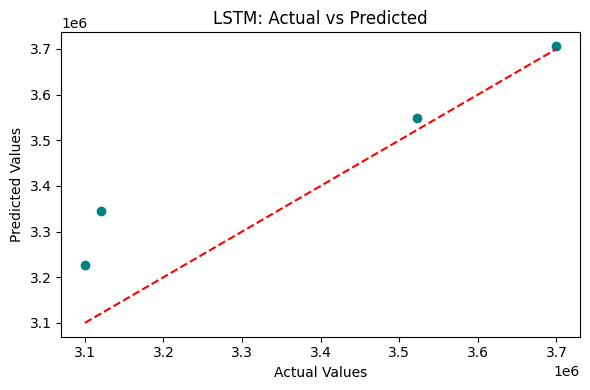

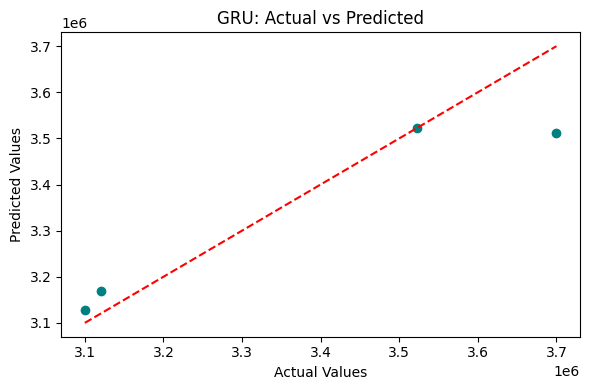

In [20]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_actual, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_actual, y_pred, color='teal')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_lstm, "LSTM: Actual vs Predicted")
plot_actual_vs_predicted(y_test, y_pred_gru, "GRU: Actual vs Predicted")
